In [1]:
import json
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import emoji
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report, confusion_matrix

import optuna

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

# **EDA**

In [210]:
df = pd.read_csv('./static/raw/train_spam.csv')

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


# Можно сделать вывод, что все поля заполнены текстовыми данными, пропусков нет.

In [212]:
df.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


# В поле text видно, что не все данные являются уникальными, но не уникальных всего лишь две строки, поэтому одну из них можно удалить.

In [213]:
df.drop_duplicates(inplace=True)

# Выведем примеры текста по каждому классу

In [214]:
df.loc[df['text_type'] == 'ham', 'text'].head(100)

0      make sure alex knows his birthday is over in f...
1      a resume for john lavorato thanks vince i will...
4      overview of hr associates analyst project per ...
6      url url date not supplied government employees...
8      looks like your ham corpus by and large has to...
                             ...                        
139    on tue 1635465 oct 1635465 angles puglisi wrot...
140    forwarded by sven guckes guckes math fu berlin...
142    p option valuation model mark after recently r...
143    no its not specialisation can work but its sla...
144    yaron s resume kevin i would greatly appreciat...
Name: text, Length: 100, dtype: object

In [215]:
df.loc[df['text_type'] == 'spam', 'text'].head(100)

2      plzz visit my website moviesgodml to get all m...
3      urgent your mobile number has been awarded wit...
5      i am so greatful to mrs valerie dodson for hel...
7      welcome to jefferson pilot s gateway to wealth...
17     keep your esignature features save 20 view onl...
                             ...                        
359    hi ho aussie w to save on your medlcatlons ove...
362    our cool medz hello welcome to medzonli decapi...
367    free step by step seminar presentation affluen...
372    we will provide you with work 1 no need to cha...
376    fyi barclays bank plc 63 st mary axe london ec...
Name: text, Length: 100, dtype: object

# Обратим внимание, что для текста класса "spam" характерно наличие смайликов. В будущем - это возможно стоит учесть.

# Посмотрим на соотношение классов в датасете

In [216]:
df.groupby(['text_type']).count()

,text
text_type,
ham,11458
spam,4809


# Очевидно, что классы с дисбалансом и текстов со спамом в 2 раза меньше, чем обычного. Из этого следует, что разбиение на train, test, valid должно быть стратифицированным.

# Рассмотрим wordcloud по всему датасету и отдельно по классам и поробуем выделить разницу между ними.

# Для всего датасета:

In [16]:
stopwords = set(stopwords.words('english'))

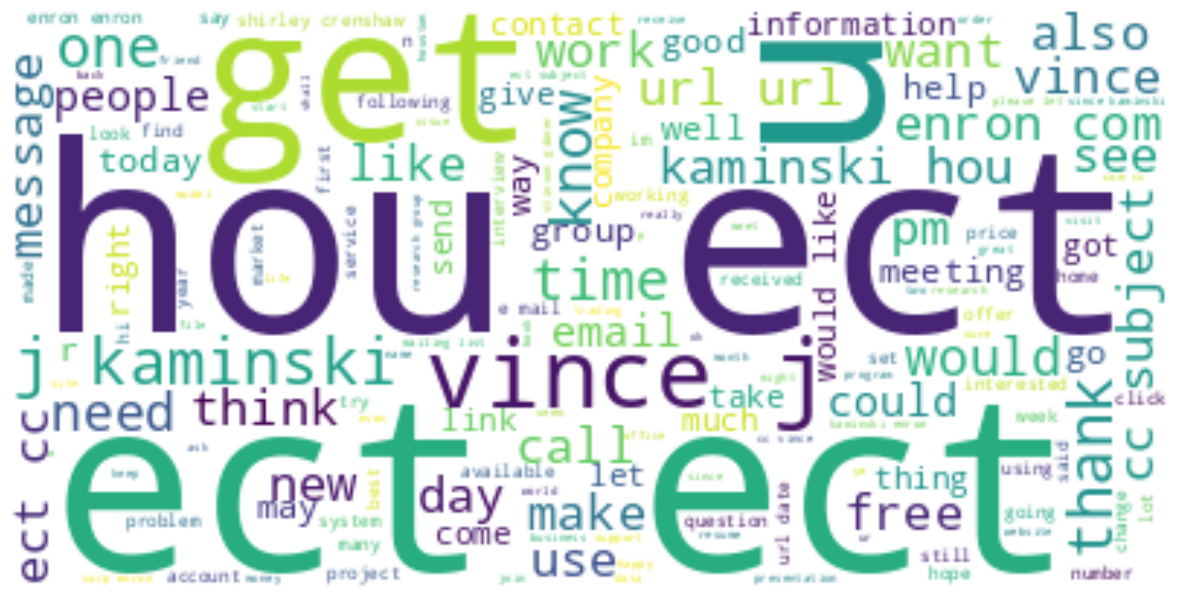

In [218]:
text = " ".join(i for i in df.text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Для данных с классом "ham"

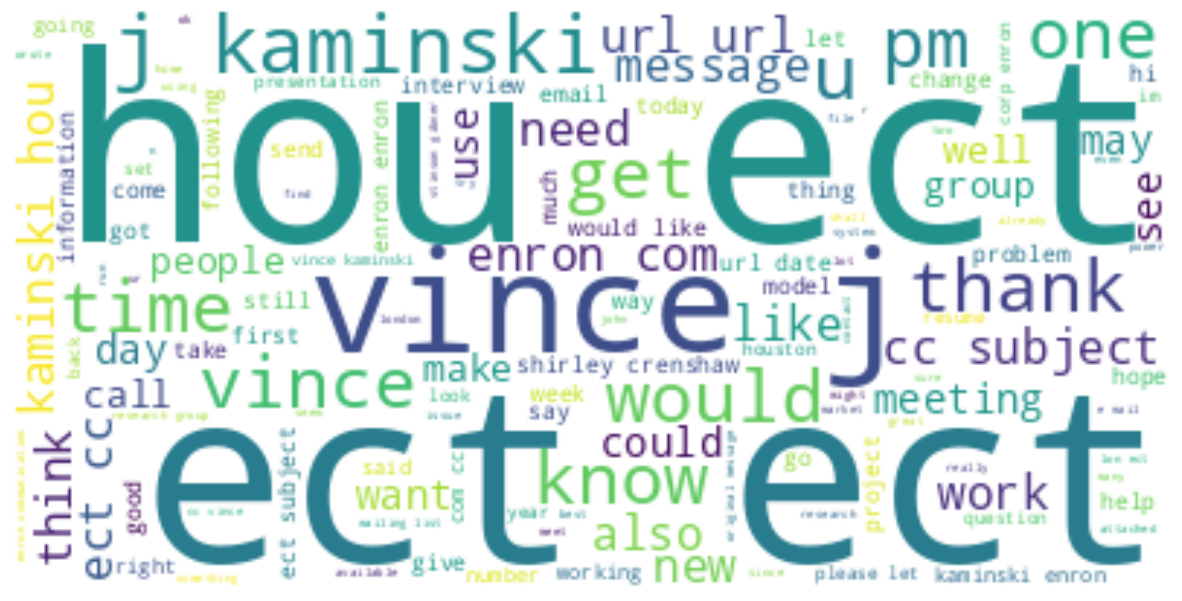

In [219]:
text = ""
text = " ".join(i for i in df.loc[df['text_type'] == 'ham',:].text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

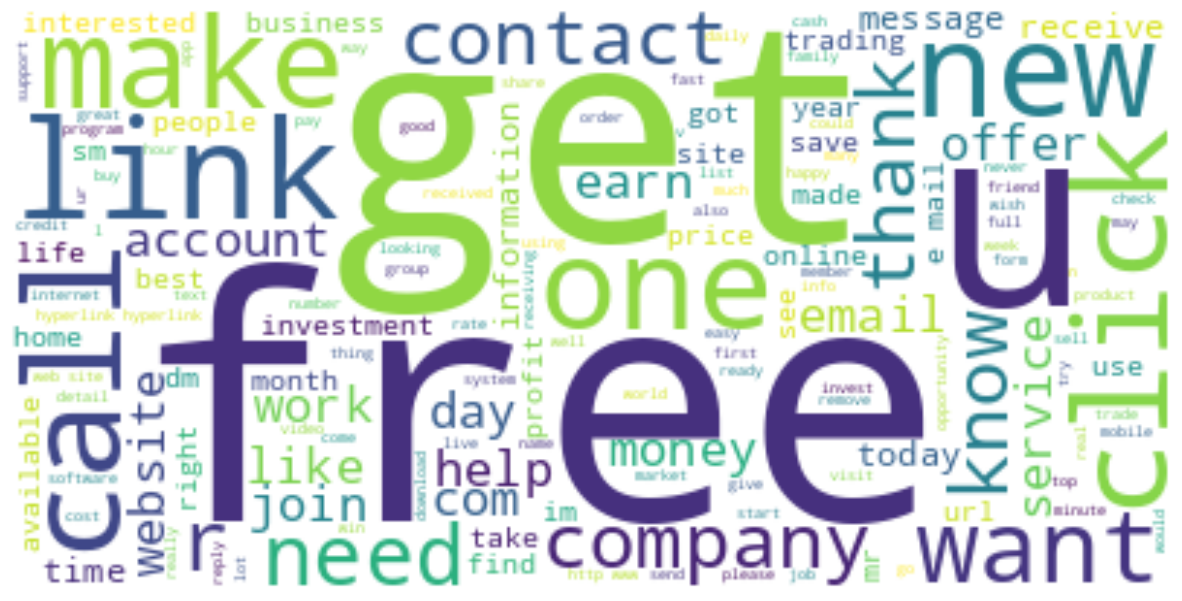

In [220]:
text = ""
text = " ".join(i for i in df.loc[df['text_type'] == 'spam',:].text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Из данного облака слов видно, что самые попопулярные слова для текста с классом "spam" отличаются от самых популярных слов для текста с классом "ham". Для спама характерны слова, призывающие к действию ("click", "contact", "call"), а также скорее всего связанные с предложением для покупки (о чём говрит слово "free"). Слово link говорит о том, что это возможно какие-то рекламы.

# Облако слов для класса "ham" не сильно отличается от облака слов по всему датасету, так как класс преобладающий в датасете.

# Таким образом, делаем вывод, что тексты с разными классам различны по своему информационному наполнению.

# Добавим в качестве признака наличие смайликов (их количество в строке).

In [221]:
df['emoji_count'] = df['text'].apply(lambda x: emoji.emoji_count(x))

<Axes: >

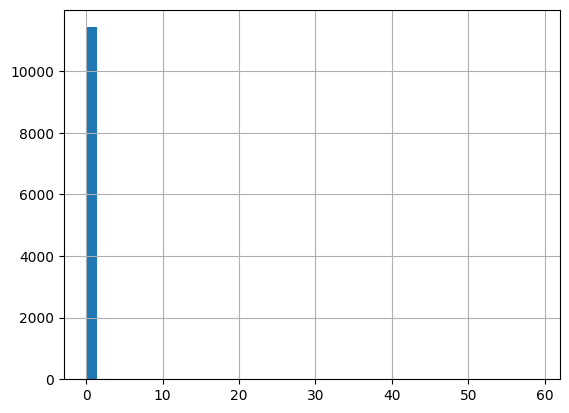

In [222]:
df[df['text_type'] == 'ham']['emoji_count'].hist(bins=40)

In [223]:
df.loc[df['text_type'] == 'ham', 'emoji_count'].describe()

count    11458.000000
mean         0.020597
std          0.607849
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         59.000000
Name: emoji_count, dtype: float64

<Axes: >

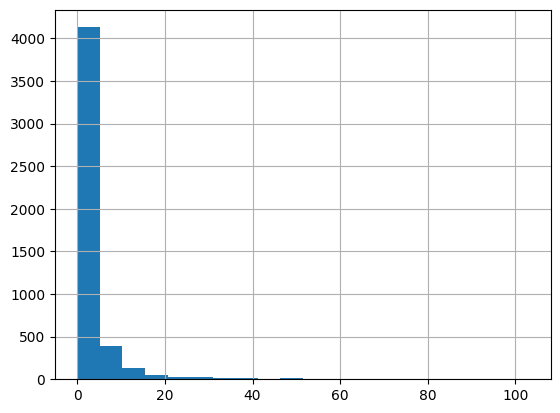

In [224]:
df.loc[df['text_type'] == 'spam', 'emoji_count'].hist(bins=20)

In [225]:
df.loc[df['text_type'] == 'spam', 'emoji_count'].describe()

count    4809.000000
mean        2.418798
std         6.906985
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       103.000000
Name: emoji_count, dtype: float64

# Различие распределений по количеству смайликов в тексте действительно наблюдается. Его можно оставить как возможный признак. Более подробный вывод о силе данного признака можно будет сделать после обучения какой-либо модели.

# Сделаем предподготовку датасета для обучения различных моделей.

# 1. Удалим стоп-слова.

In [226]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [227]:
df['preprocess_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [244]:
df

,text_type,text,emoji_count,preprocess_text,label
0,ham,make sure alex knows his birthday is over in f...,0,make sure alex knows birthday fifteen minutes ...,0
1,ham,a resume for john lavorato thanks vince i will...,0,resume john lavorato thanks vince get moving r...,0
2,spam,plzz visit my website moviesgodml to get all m...,5,plzz visit website moviesgodml get movies free...,1
3,spam,urgent your mobile number has been awarded wit...,0,urgent mobile number awarded prize guaranteed ...,1
4,ham,overview of hr associates analyst project per ...,0,overview hr associates analyst project per dav...,0
...,...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,0,interested binary options trading may continue...,1
16274,spam,dirty pictureblyk on aircel thanks you for bei...,0,dirty pictureblyk aircel thanks valued member ...,1
16275,ham,or you could do this g on mon 1635465 sep 1635...,0,could g mon 1635465 sep 1635465 david rees wro...,0
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,2,insta reels par 80 bhara pada hai kuch bhi dal...,0


# 2. Текст без пунктуации 

In [15]:
def delete_punkt(text: str) -> str:
    words = nltk.word_tokenize(text)
    return ' '.join([word for word in words if word.isalnum()])

In [230]:
df['preprocess_text'] = df['preprocess_text'].apply(lambda x: delete_punkt(x))

In [231]:
df

,text_type,text,emoji_count,preprocess_text
0,ham,make sure alex knows his birthday is over in f...,0,make sure alex knows birthday fifteen minutes ...
1,ham,a resume for john lavorato thanks vince i will...,0,resume john lavorato thanks vince get moving r...
2,spam,plzz visit my website moviesgodml to get all m...,5,plzz visit website moviesgodml get movies free...
3,spam,urgent your mobile number has been awarded wit...,0,urgent mobile number awarded prize guaranteed ...
4,ham,overview of hr associates analyst project per ...,0,overview hr associates analyst project per dav...
...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,0,interested binary options trading may continue...
16274,spam,dirty pictureblyk on aircel thanks you for bei...,0,dirty pictureblyk aircel thanks valued member ...
16275,ham,or you could do this g on mon 1635465 sep 1635...,0,could g mon 1635465 sep 1635465 david rees wro...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,2,insta reels par 80 bhara pada hai kuch bhi dal...


# Присвоим классам численные значения 0 и 1

In [232]:
def to_label(text: str) -> int:
    return 0 if text == 'ham' else 1

In [233]:
df['label'] = df['text_type'].apply(lambda x: to_label(x))

In [234]:
df

,text_type,text,emoji_count,preprocess_text,label
0,ham,make sure alex knows his birthday is over in f...,0,make sure alex knows birthday fifteen minutes ...,0
1,ham,a resume for john lavorato thanks vince i will...,0,resume john lavorato thanks vince get moving r...,0
2,spam,plzz visit my website moviesgodml to get all m...,5,plzz visit website moviesgodml get movies free...,1
3,spam,urgent your mobile number has been awarded wit...,0,urgent mobile number awarded prize guaranteed ...,1
4,ham,overview of hr associates analyst project per ...,0,overview hr associates analyst project per dav...,0
...,...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,0,interested binary options trading may continue...,1
16274,spam,dirty pictureblyk on aircel thanks you for bei...,0,dirty pictureblyk aircel thanks valued member ...,1
16275,ham,or you could do this g on mon 1635465 sep 1635...,0,could g mon 1635465 sep 1635465 david rees wro...,0
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,2,insta reels par 80 bhara pada hai kuch bhi dal...,0


# Сделаем разбиения датасета на три части:
# train - на который будут обучаться модели
# valid - на которой будут подбираться гиперпараметры
# test -  на которой будут тестироваться обученные модели
# Так как классы не сбалансированные, то будем использовать стратификацию, чтобы сохранить соотношение классов в каждом из частей разбиения. Аргумент random_state с его значением необходим для воспроизводимости результата.

In [235]:
train, test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=42)

# Используем стратификацию из-за дисбаланса классов
# random-state для воспроизводимости результата

In [236]:
test, valid, y_test, y_valid = train_test_split(test, y_test, test_size=0.5, shuffle=True, random_state=42)

# Сохраним для возможности дальнейшего переиспользования

In [237]:
train

,text_type,text,emoji_count,preprocess_text,label
14494,ham,i m playng wid d gm jo tune mujhe diya tha boo...,0,playng wid gm jo tune mujhe diya tha boost wal...,0
8915,ham,usually the body takes care of it buy making s...,0,usually body takes care buy making sure doesnt...,0
15930,spam,free fire about 3hrs,0,free fire 3hrs,1
7095,spam,i have heard a lot of stories of how bitcoin c...,0,heard lot stories bitcoin crypto forex changed...,1
14051,ham,url url date tue 1635465 sep 1635465 1635465 1...,0,url url date tue 1635465 sep 1635465 1635465 1...,0
...,...,...,...,...,...
1493,ham,from slate s today s papers the new york times...,0,slate today papers new york times los angeles ...,0
13088,ham,i wonder if the focus of spambayes ought not t...,0,wonder focus spambayes ought classifier leaves...,0
9085,ham,on fri 1635465 sep 1635465 tony tony nugent wr...,0,fri 1635465 sep 1635465 tony tony nugent wrote...,0
2756,ham,vince s london visit hi wendy we have finally ...,0,vince london visit hi wendy finally made arran...,0


In [238]:
train.to_csv('./static/preprocess/train.csv', index=False)
test.to_csv('./static/preprocess/test.csv', index=False)
valid.to_csv('./static/preprocess/valid.csv', index=False)

# Обучение моделей

# В качестве baseline модели возьмём легкореализуемую модель из классического машинного обучения

# Для задачи классификации сообщения на spam/ham сильной baseline моделью является наивный байесовский классификатор

# Общий подход к обучения будет выглядеть следующим образом:
# 1. Выберем модель, которую хотим обучить
# 2. Обучаем модель на train
# 3. Используем valid во время обучения для подбора гиперпараметров и контроля модели от переобучения
# 4. Обученную модель, тестируем на test
# 5. Делаем вывод исходя из получившихся результатов
# 6. Пытаемся улучшить результат

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB

In [35]:
y_train, y_test, y_valid = np.array(y_train), np.array(y_test), np.array(y_valid)

# Для обучения будем пользоваться пакетом sklearn, которые предоставляет ращличные вариации наивного байесовского классификатора.
# В данном случае для обучения будут использованы три различные вариации: BernoulliNB, MultinomialNB, ComplementNB. Различаются они предположением о том, как распределение признаки для классификации. Для того чтобы получить наилучший результат, можем попроовать каждый из них.


# Для того чтобы обучить навный байессовский классификатор - нужно сначала получить признаки. Для это необходимо векторизовать текст.
# Для векторизации текста будем использовать два различных "векторизатора": CountVectorizer, TfidfVectorizer
# Первый из них вернёт для коллекции текстов матрицу с количеством тоекнов. Второй вернёт матрицу с tf-idf признаками.

# Для того чтобы подобрать наилучшую комбинацию классификатора и "векторизатора", будем использовать библиотеку Optunа, которая помогает подбирать гиперпараметры обучаемых моделей. По оцениваемым скором является roc-auc-score, то поставим задачу его максимизации.
# Алгоритм подбора следующий:
# 1. На каждом шаге определяется тип классификатора и векторизатора и задаются их гиперепараметры
# 2. Модель обучается на train
# 3. Валидируется на valid

# P.S.: В данном случае, я воспринимаю конкретные реализации классификатора и векторизатора как гиперпараметры.

In [48]:
X_train = train['preprocess_text']
X_test = test['preprocess_text']
X_valid = valid['preprocess_text']

In [42]:
def objective(trial):
    global X_train, X_valid, y_train, y_valid    
    
    vectorizer_name = trial.suggest_categorical("tokenizer", ["Count", "TfIdf"])
    if vectorizer_name == "Count":
        vectorizer = CountVectorizer()
    else:
        vectorizer = TfidfVectorizer()
        
    classifier = None
    classifier_name = trial.suggest_categorical("classifier", ["BernoulliNB", "MultinomialNB", "ComplementNB"])      
    if classifier_name == "BernoulliNB":
        alpha = trial.suggest_float("alpha", 0.01, 1)
        classifier = BernoulliNB(alpha=alpha)
    elif classifier_name == "MultinomialNB":
        alpha = trial.suggest_float("alpha", 0.01, 1)
        classifier = MultinomialNB(alpha=alpha)
    elif classifier_name == "ComplementNB":
        alpha = trial.suggest_float("alpha", 0.01, 1)
        classifier = ComplementNB(alpha=alpha)
        
    
    X_tr, X_val = vectorizer.fit_transform(X_train), vectorizer.transform(X_valid)
    classifier.fit(X_tr, y_train)
    y_predict = classifier.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_valid, y_predict)
    return score
        
        
        

In [43]:
study = optuna.create_study(direction="maximize")

[I 2024-05-03 13:02:10,694] A new study created in memory with name: no-name-6d6b4bd2-37c7-4251-9cc9-07aeb4a78d26


In [ ]:
study.optimize(objective, n_trials=1000)

# Выведем лучшее соотношение, и согласно ему обучим конечный вариант байесовского классификатора

In [55]:
print(study.best_params)

{'tokenizer': 'TfIdf', 'classifier': 'BernoulliNB', 'alpha': 0.9773569108895576}


In [56]:
from sklearn.pipeline import Pipeline

In [57]:
pipeline = Pipeline([('vectorizer', CountVectorizer()), 
                     ('classifier', BernoulliNB(alpha=study.best_params['alpha']))])

In [58]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', BernoulliNB(alpha=0.9773569108895576))])

In [66]:
y_predict_proba = pipeline.predict_proba(X_test)[:, 1]
y_predict_labels = pipeline.predict(X_test)

In [77]:
score = roc_auc_score(y_test, y_predict_proba)
print(f"roc-auc-sore: {score}")

roc-auc-sore: 0.981925087108014


# Построим roc кривую

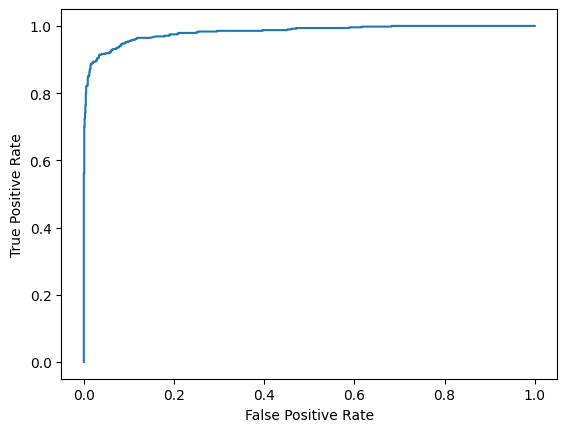

In [80]:
fpr, tpr, _ = roc_curve(test['label'],  y_predict_proba)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
print(classification_report(y_test, y_predict_labels))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1148
           1       0.99      0.76      0.86       480

    accuracy                           0.93      1628
   macro avg       0.95      0.88      0.91      1628
weighted avg       0.93      0.93      0.92      1628


In [75]:
print(confusion_matrix(y_test, y_predict_labels))

[[1143    5]
 [ 113  367]]


# При достаточно хорошем показателе roc-auc-score для baseline модели, анализ другихметрик классификации показывает достаточно низкий recall, что говорит о плохой способности отделения класса spam от ham.

In [62]:
best_params = study.best_params
best_params['valid_score'] = study.best_value
best_params['test_score'] = score

# Сохраним получившееся параметры обучения и score

In [64]:
with open('/home/danila/Projects/vk-intern/NB/params.json', 'w') as fp:
    json.dump(best_params, fp)

# Сохраним модель классификатора

In [65]:
joblib.dump(pipeline, "/home/danila/Projects/vk-intern/NB/nb_pipeline.joblib")

['/home/danila/Projects/vk-intern/NB/nb_pipeline.joblib']

# Попробуем улучшить результат использую подход не классиеского машинного обучения, а нейросетевой. Таким подходом может являться FastText.

# FastText

# Будем использовать библиотеку fasttext, которая позволяет сделать классификацию текста

In [84]:
import fasttext

# У данной библиотеки есть свой формат, в котором должен быть подготовлен датасет

# Создадим такой датасет

In [90]:
fasttext_train = train[['text_type', 'preprocess_text']]
fasttext_valid = valid[['text_type', 'preprocess_text']]

In [ ]:
fasttext_train['label'] = "__label__" + fasttext_train['text_type']
fasttext_valid['label'] = "__label__" + fasttext_valid['text_type']

In [ ]:
fasttext_train['text'] = fasttext_train['label'] + " " + fasttext_train['preprocess_text']
fasttext_valid['text'] = fasttext_valid['label'] + " " + fasttext_valid['preprocess_text']

In [94]:
fasttext_train.to_csv('/home/danila/Projects/vk-intern/fasttext/preprocess/fasttext.train', columns=['text'], header=False, index=False)
fasttext_valid.to_csv('/home/danila/Projects/vk-intern/fasttext/preprocess/fasttext.valid', columns=['text'], header=False, index=False)

# Обучим, оптимизирую гиперепараметры с помощью Optuna

In [103]:
def objective(trial):
    
    lr = trial.suggest_float("lr", 0.1, 1.0)
    epoch = trial.suggest_int("epoch", 5, 30)
    word_Ngrams = trial.suggest_int("wordNgrams", 1, 5)
    
    fasttext_model = fasttext.train_supervised('/home/danila/Projects/vk-intern/fasttext/preprocess/fasttext.train', lr=lr, epoch=epoch, wordNgrams=word_Ngrams)
    
    samples, precision, recall = fasttext_model.test('/home/danila/Projects/vk-intern/fasttext/preprocess/fasttext.valid')
    
    return precision, recall
        
        
        

In [104]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), directions=['maximize', 'maximize'])

[I 2024-05-03 14:23:00,567] A new study created in memory with name: no-name-557429d6-3ed7-4d71-bb54-4d28a95561e4


In [105]:
study.optimize(objective, n_trials=150)

Read 0M words
Number of words:  46615
Number of labels: 2
Progress: 100.0% words/sec/thread:  417389 lr:  0.000000 avg.loss:  0.047746 ETA:   0h 0m 0s
[I 2024-05-03 14:23:04,315] Trial 0 finished with values: [0.9502457002457002, 0.9502457002457002] and parameters: {'lr': 0.5309590589423092, 'epoch': 23, 'wordNgrams': 3}. 
Read 0M words
Number of words:  46615
Number of labels: 2
Progress: 100.0% words/sec/thread:  262635 lr:  0.000000 avg.loss:  0.041282 ETA:   0h 0m 0s
[I 2024-05-03 14:23:08,184] Trial 1 finished with values: [0.9508599508599509, 0.9508599508599509] and parameters: {'lr': 0.5559005817679317, 'epoch': 24, 'wordNgrams': 4}. 
Read 0M words
Number of words:  46615
Number of labels: 2
Progress: 100.0% words/sec/thread:  192338 lr:  0.000000 avg.loss:  0.075941 ETA:   0h 0m 0s
[I 2024-05-03 14:23:10,791] Trial 2 finished with values: [0.9398034398034398, 0.9398034398034398] and parameters: {'lr': 0.7170022160716325, 'epoch': 10, 'wordNgrams': 5}. 
Read 0M words
Number of w

# Извлечём лучшие гиперпараметры из попыток и обучим модель на них

In [114]:
best_params = study.best_trials[0].params

In [115]:
fasttext_model = fasttext.train_supervised('/home/danila/Projects/vk-intern/fasttext/preprocess/fasttext.train', lr=best_params['lr'], epoch=best_params['epoch'], wordNgrams=best_params['wordNgrams'])

Read 0M words
Number of words:  46615
Number of labels: 2
Progress: 100.0% words/sec/thread:  721743 lr:  0.000000 avg.loss:  0.049733 ETA:   0h 0m 0s


# Сохраним модель и гиперпараметры

In [133]:
fasttext_model.save_model("/home/danila/Projects/vk-intern/fasttext/fasttext_model.bin")

In [134]:
with open('/home/danila/Projects/vk-intern/fasttext/params.json', 'w') as fp:
    json.dump(best_params, fp)

# Напишем метод, который делает предсказание класса и вероятности

In [26]:
def fasttext_predict(model, text: str):
    label, proba = model.predict(text)
    if label[0] == "__label__spam":
        return label[0][9:], proba[0]
    else:
        proba = 1 - proba[0]
        proba = 0 if proba < 0 else proba
        return label[0][9:], proba

# Проанализируем получившейся результат на test

In [127]:
y_predict_proba = []
y_predict_labels = []
for index, row in test.iterrows():
    label, proba = fasttext_predict(fasttext_model, row['preprocess_text'])
    y_predict_proba.append(proba)
    y_predict_labels.append(1 if label == 'spam' else 0)

In [137]:
score = roc_auc_score(y_test, y_predict_proba)
print(f"roc-auc-sore: {score}")

roc-auc-sore: 0.9835628992450638


# Построим roc кривую

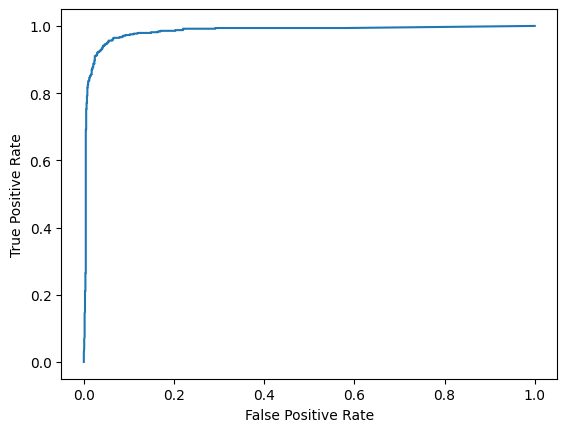

In [138]:
fpr, tpr, _ = roc_curve(test['label'], y_predict_proba)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [131]:
print(classification_report(y_test, y_predict_labels))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1148
           1       0.93      0.91      0.92       480

    accuracy                           0.95      1628
   macro avg       0.95      0.94      0.94      1628
weighted avg       0.95      0.95      0.95      1628


In [132]:
print(confusion_matrix(y_test, y_predict_labels))

[[1117   31]
 [  43  437]]


# Выводы:
# 1. Показатель roc-auc-score на тесте относительно предыдущего наивного байесовского классификатора вырос
# 2. Есть падение presion для класса spam, но гораздо более значительный рост recall. Если посмотреть f1-socre для обоих классов, то они выросли относительно байссовского классификатора. То есть в среднем модель предсказывает лучше, чем наивный байесовский классификатор.

# Таким образом, на данный момент выбор между моделями останаваливается на fasttext.

# Однако, можно попробовать ещё улучшить результат использовав гораздо более сложную модель, такую как BERT, в качестве классификатора.

# Finetuning BERT

# Импортируем необходимые библиотеки для finetunig-a модели

In [6]:
import torch
import datasets
from transformers import BertTokenizer, BertForSequenceClassification,Trainer, TrainingArguments

In [153]:
train = pd.read_csv('/home/danila/Projects/vk-intern/static/preprocess/train.csv')
test = pd.read_csv('/home/danila/Projects/vk-intern/static/preprocess/test.csv')
valid = pd.read_csv('/home/danila/Projects/vk-intern/static/preprocess/valid.csv')

In [154]:
train_bert = datasets.Dataset.from_pandas(train[['text', 'label']])
test_bert = datasets.Dataset.from_pandas(test[['text', 'label']])
valid_bert = datasets.Dataset.from_pandas(valid[['text', 'label']])

In [155]:
train_bert

Dataset({
    features: ['text', 'label'],
    num_rows: 13013
})

# Загрузим предобученные веса модели

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length = 512)

/home/danila/Projects/vk-intern/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Напишем функцию которая токенезирует текст, токенизатором BERT
# padding и truncation будут регулировать длину тензоров, чтобы они были одинаковой длины внутри batch-а
# padding - будет добавлять специальные pad-токены увеличивая длину
# truncation - наоборот обрезать

In [8]:
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = True, truncation=True)

In [161]:
train_bert = train_bert.map(tokenization, batched = True, batch_size=len(train_bert))
test_bert = test_bert.map(tokenization, batched = True, batch_size=len(test_bert))
valid_bert = valid_bert.map(tokenization, batched = True, batch_size=len(valid_bert))

Map:   0%|          | 0/13013 [00:00<?, ? examples/s]

Map:   0%|          | 0/1627 [00:00<?, ? examples/s]

Map:   0%|          | 0/1627 [00:00<?, ? examples/s]

# Переведём всё в формат pytorch

In [16]:
train_bert.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_bert.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
valid_bert.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [162]:
from sklearn.metrics import precision_recall_fscore_support

# Напишем функцию, которая будет рассчитывать метрики во время валидации модели

In [164]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    roc_auc = roc_auc_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

# Создадим параметры, которые регулируют процесс обучения

In [18]:
training_args = TrainingArguments(
    output_dir = './bert-tune',
    num_train_epochs=3,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 2,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps = 8,
    fp16 = True,
    logging_dir='./bert-logs',
    dataloader_num_workers = 8,
    run_name = 'bert-classification'
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_bert,
    eval_dataset=valid_bert
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Запустим обучение

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
0,0.065800,0.122261,0.968654,0.945455,0.975717,0.917012,0.953703
1,0.084900,0.068570,0.977259,0.961498,0.964509,0.958506,0.971830
2,0.065600,0.074061,0.980947,0.968008,0.963039,0.973029,0.978654


TrainOutput(global_step=1218, training_loss=0.11485426757662069, metrics={'train_runtime': 4541.9617, 'train_samples_per_second': 8.595, 'train_steps_per_second': 0.268, 'total_flos': 1.025449027160064e+16, 'train_loss': 0.11485426757662069, 'epoch': 2.9949285384970032})

In [9]:
model = BertForSequenceClassification.from_pretrained('./bert-tune/checkpoint-1218')

In [10]:
device = 'cuda'

In [11]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Напишем функции для предсказания класса и его вероятности

In [30]:
def bert_predict(tokenizer, model, text: str):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    ids = tokens['input_ids'].to(device, dtype = torch.long)
    mask = tokens['attention_mask'].to(device, dtype = torch.long)
    y = model(ids, mask)
    val, ids = torch.max(y.logits.detach().cpu(), dim=1)
    label = ids.numpy()[0]
    proba = torch.nn.functional.softmax(y.logits.detach().cpu(), dim=1).numpy()[0, 1]
    return label, proba

In [180]:
y_predict_proba = []
y_predict_labels = []
for index, row in test.iterrows():
    label, proba = bert_predict(tokenizer, model, row['text'])
    y_predict_proba.append(proba)
    y_predict_labels.append(label)

In [184]:
score = roc_auc_score(test['label'], y_predict_proba)
print(f"roc-auc-sore: {score}")

roc-auc-sore: 0.9937990409764604


# Построим roc-кривую

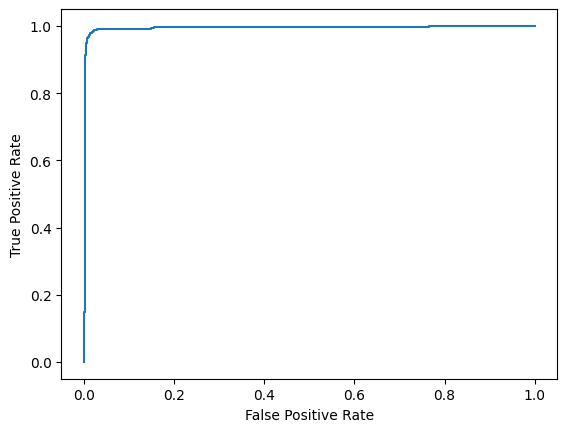

In [186]:
fpr, tpr, _ = roc_curve(test['label'], y_predict_proba)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [189]:
print(classification_report(test['label'], y_predict_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1147
           1       0.98      0.96      0.97       480

    accuracy                           0.98      1627
   macro avg       0.98      0.98      0.98      1627
weighted avg       0.98      0.98      0.98      1627


In [191]:
print(confusion_matrix(test['label'], y_predict_labels))

[[1136   11]
 [  17  463]]


# Вывод: finetuning BERT-а дал наилучший результат из трёх представленных моделей на test, как по целевой метрике roc-auc, так и по иным метрика классификации, такие precision, recall, f1-score. Поэтому предпочтение отдаётся BERT.

# Попробуем улучшить результат, агрегировав вероятности от трёх моделей.

# Для того чтобы понять, как правильно учитывать вероятности от каждой модели, можем попробовать обучить Логистическую регрессию и посмотреть её коэффициенты. Добавим туда признак количества смайликов, возможно, он улучшит классификацию.

In [273]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [254]:
train_meta = pd.DataFrame()
valid_meta = pd.DataFrame()
test_meta = pd.DataFrame()

In [255]:
train

,text_type,text,emoji_count,preprocess_text,label
0,ham,i m playng wid d gm jo tune mujhe diya tha boo...,0,playng wid gm jo tune mujhe diya tha boost wal...,0
1,ham,usually the body takes care of it buy making s...,0,usually body takes care buy making sure doesnt...,0
2,spam,free fire about 3hrs,0,free fire 3hrs,1
3,spam,i have heard a lot of stories of how bitcoin c...,0,heard lot stories bitcoin crypto forex changed...,1
4,ham,url url date tue 1635465 sep 1635465 1635465 1...,0,url url date tue 1635465 sep 1635465 1635465 1...,0
...,...,...,...,...,...
13008,ham,from slate s today s papers the new york times...,0,slate today papers new york times los angeles ...,0
13009,ham,i wonder if the focus of spambayes ought not t...,0,wonder focus spambayes ought classifier leaves...,0
13010,ham,on fri 1635465 sep 1635465 tony tony nugent wr...,0,fri 1635465 sep 1635465 tony tony nugent wrote...,0
13011,ham,vince s london visit hi wendy we have finally ...,0,vince london visit hi wendy finally made arran...,0


# Сгенерируем вероятности наивным байесовским классификатором

In [256]:
train_meta['nb_proba'] = train['preprocess_text'].apply(lambda x: pipeline.predict_proba([x])[0, 1])
valid_meta['nb_proba'] = valid['preprocess_text'].apply(lambda x: pipeline.predict_proba([x])[0, 1])
test_meta['nb_proba'] = test['preprocess_text'].apply(lambda x: pipeline.predict_proba([x])[0, 1])

# Сгенерируем вероятности fasttext

In [280]:
train_meta['ft_proba'] = train['preprocess_text'].apply(lambda x: fasttext_predict(fasttext_model, x)[1])
valid_meta['ft_proba'] = valid['preprocess_text'].apply(lambda x: fasttext_predict(fasttext_model, x)[1])
test_meta['ft_proba'] = test['preprocess_text'].apply(lambda x: fasttext_predict(fasttext_model, x)[1])

# Сгенерируем вероятности BERT

In [316]:
train_meta['bert_proba'] = train['text'].apply(lambda x: bert_predict(tokenizer, model, x)[1])
valid_meta['bert_proba'] = valid['text'].apply(lambda x: bert_predict(tokenizer, model, x)[1])
test_meta['bert_proba'] = test['text'].apply(lambda x: bert_predict(tokenizer, model, x)[1])

# Сохраним признаки смайликов

In [265]:
train_meta['emoji_count'] = train['emoji_count']
valid_meta['emoji_count'] = valid['emoji_count']
test_meta['emoji_count'] = test['emoji_count']

# Сохраним таргеты

In [266]:
train_meta['label'] = train['label']
valid_meta['label'] = valid['label']
test_meta['label'] = test['label']

# Примение minmaxscaler для того чтобы отмасштабировать признак количества смайликов к промежутку [0, 1]

In [267]:
scaler = MinMaxScaler()

In [270]:
train_meta['emoji_count_transform'] = scaler.fit_transform(train_meta[['emoji_count']])

In [317]:
meta_model = LogisticRegression()

In [318]:
meta_model.fit(train_meta[['nb_proba', 'ft_proba', 'bert_proba', 'emoji_count_transform']], train_meta['label'])

LogisticRegression()

In [319]:
meta_model.coef_

array([[ 0.99576801,  6.38782644,  6.55060259, -0.21823635]])

# Логистическая регрессия имеет самый маленький коэффициент перед признаком кол-ва смайликов, так что в итоге, его можно не использовать.
# Для вероятностей от каждой модели можем придумать коэффициенты в таком же соотношении, что и веса логистической регресии.

In [328]:
test_meta['res_proba'] = test_meta['ft_proba']*0.4 + test_meta['bert_proba']*0.5 + test_meta['nb_proba']*0.1

In [329]:
roc_auc_score(test_meta['label'], test_meta['res_proba'])

0.9977059721011334

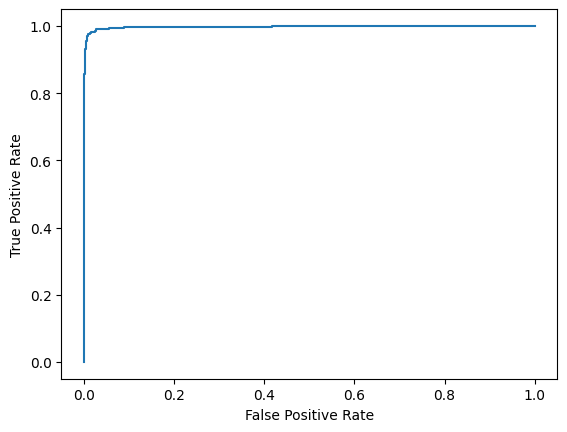

In [322]:
fpr, tpr, _ = roc_curve(test_meta['label'], test_meta['res_proba'])
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# После агрегирования видно, что целевая метрика roc-auc улучшилась на тесте. Поэтому идею с агрегацией весов можно использовать./home/danila/Project

# Вывод: таким образом, итоговое решение заключается в использовании всех трёх моделей, с учётом каждой вероятности с соответствующим весовым коэффициентом.

# Проскорим тестовую выборку.

In [38]:
test_df = pd.read_csv('./static/raw/test_spam.csv')

In [39]:
test_df

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


# Удалим стоп-слова и пунктуацию

In [40]:
test_df['text'] = test_df['text'].apply(lambda x: x.lower())
test_df['preprocess_text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
test_df

,text,preprocess_text
0,j jim whitehead ejw cse ucsc edu writes j you ...,j jim whitehead ejw cse ucsc edu writes j open...
1,original message from bitbitch magnesium net p...,original message bitbitch magnesium net people...
2,java for managers vince durasoft who just taug...,java managers vince durasoft taught java class...
3,there is a youtuber name saiman says,youtuber name saiman says
4,underpriced issue with high return on equity t...,underpriced issue high return equity oil gas a...
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,husband wifetum meri zindagi hoorwifeor kyatel...
4066,baylor enron case study cindy yes i shall co a...,baylor enron case study cindy yes shall co aut...
4067,boring as compared to tp,boring compared tp
4068,hellogorgeous hows u my fone was on charge lst...,hellogorgeous hows u fone charge lst nitw wen ...


In [41]:
test_df['preprocess_text'] = test_df['preprocess_text'].apply(lambda x: delete_punkt(x))

In [42]:
test_df

,text,preprocess_text
0,j jim whitehead ejw cse ucsc edu writes j you ...,j jim whitehead ejw cse ucsc edu writes j open...
1,original message from bitbitch magnesium net p...,original message bitbitch magnesium net people...
2,java for managers vince durasoft who just taug...,java managers vince durasoft taught java class...
3,there is a youtuber name saiman says,youtuber name saiman says
4,underpriced issue with high return on equity t...,underpriced issue high return equity oil gas a...
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,husband wifetum meri zindagi hoorwifeor kyatel...
4066,baylor enron case study cindy yes i shall co a...,baylor enron case study cindy yes shall co aut...
4067,boring as compared to tp,boring compared tp
4068,hellogorgeous hows u my fone was on charge lst...,hellogorgeous hows u fone charge lst nitw wen ...


# Предскажем необходимые вероятности

In [43]:
test_df['nb_proba'] = test_df['preprocess_text'].apply(lambda x: pipeline.predict_proba([x])[0, 1])

In [44]:
test_df['ft_proba'] = test_df['preprocess_text'].apply(lambda x: fasttext_predict(fasttext_model, x)[1])

In [ ]:
test_df['bert_proba'] = test_df['text'].apply(lambda x: bert_predict(tokenizer, model, x)[1])

In [ ]:
test_df['score'] = test_df['ft_proba']*0.4 + test_df['bert_proba']*0.5 + test_df['nb_proba']*0.1

In [ ]:
test_df

In [35]:
test_df = test_df[['text', 'score']]

In [36]:
test_df

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.000743
1,original message from bitbitch magnesium net p...,0.008357
2,java for managers vince durasoft who just taug...,0.000184
3,there is a youtuber name saiman says,0.000774
4,underpriced issue with high return on equity t...,0.973338
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0.000976
4066,baylor enron case study cindy yes i shall co a...,0.000060
4067,boring as compared to tp,0.000696
4068,hellogorgeous hows u my fone was on charge lst...,0.000065


In [37]:
test_df.to_csv('/home/danila/Projects/vk-intern/submission.csv', index=False)